# 1. CÀI ĐẶT THƯ VIỆN

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from lightgbm import LGBMRegressor,early_stopping, log_evaluation

# 2. ĐỌC VÀ TIỀN XỬ LÝ DỮ LIỆU

In [2]:
df = pd.read_csv("Gold Futures Historical Data.csv")

# Đổi tên cột cho dễ xử lý
df.columns = ["Date", "Price", "Open", "High", "Low", "Volume", "Change"]

# Đổi format ngày và sắp xếp tăng dần theo thời gian
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df = df.sort_values("Date").reset_index(drop=True)

# Xử lý dữ liệu số: bỏ dấu "," và "%"
df["Price"] = df["Price"].str.replace(",", "").astype(float)
df["Open"] = df["Open"].str.replace(",", "").astype(float)
df["High"] = df["High"].str.replace(",", "").astype(float)
df["Low"] = df["Low"].str.replace(",", "").astype(float)
df["Volume"] = df["Volume"].str.replace("K", "").str.replace(",", "").astype(float) * 1_000
df["Change"] = df["Change"].str.replace("%", "").astype(float)

df.head()


,Date,Price,Open,High,Low,Volume,Change
0,2022-01-03,1800.1,1830.1,1833.0,1798.2,168310.0,-1.56
1,2022-01-04,1814.6,1801.1,1817.2,1798.1,167710.0,0.81
2,2022-01-05,1825.1,1815.2,1830.7,1808.2,173340.0,0.58
3,2022-01-06,1789.2,1810.6,1811.6,1785.4,238640.0,-1.97
4,2022-01-07,1797.4,1791.0,1798.4,1781.3,238930.0,0.46


# 3. CHUẨN HOÁ DỮ LIỆU

In [3]:
scaler = StandardScaler()

features = ["Open", "High", "Low", "Volume", "Change"]
target = "Price"

scaled_features = scaler.fit_transform(df[features])
df_scaled = pd.DataFrame(scaled_features, columns=features)
df_scaled["Price"] = df["Price"]
df_scaled["Date"] = df["Date"]


# 4. CHIA TẬP TRAIN/TEST

In [4]:
split_index = int(len(df_scaled) * 0.9)
train_df = df_scaled.iloc[:split_index]
test_df = df_scaled.iloc[split_index:]

X_train = train_df[features]
y_train = train_df["Price"]
X_test = test_df[features]
y_test = test_df["Price"]


# 5. HUẤN LUYỆN MÔ HÌNH

In [5]:
model = LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    learning_rate=0.01,
    num_leaves=31,
    max_depth=-1,
    feature_fraction=0.9,      
    bagging_fraction=0.8,      
    bagging_freq=5,            
    n_estimators=1000,
    verbose=-1                 
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='rmse',
    callbacks=[
        early_stopping(50),
        log_evaluation(period=100)  # Log mỗi 100 vòng
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 80.4632	training's l2: 6474.33	valid_1's rmse: 359.966	valid_1's l2: 129575
[200]	training's rmse: 30.5118	training's l2: 930.968	valid_1's rmse: 237.011	valid_1's l2: 56174.1
[300]	training's rmse: 12.9214	training's l2: 166.963	valid_1's rmse: 192.146	valid_1's l2: 36920.1
[400]	training's rmse: 7.46636	training's l2: 55.7465	valid_1's rmse: 175.395	valid_1's l2: 30763.4
[500]	training's rmse: 6.00763	training's l2: 36.0917	valid_1's rmse: 169.956	valid_1's l2: 28885.1
[600]	training's rmse: 5.44344	training's l2: 29.6311	valid_1's rmse: 167.868	valid_1's l2: 28179.6
[700]	training's rmse: 5.11974	training's l2: 26.2118	valid_1's rmse: 166.613	valid_1's l2: 27760
Early stopping, best iteration is:
[720]	training's rmse: 5.06578	training's l2: 25.6621	valid_1's rmse: 166.528	valid_1's l2: 27731.7


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.9,
              learning_rate=0.01, n_estimators=1000, objective='regression',
              verbose=-1)

# 6. DỰ ĐOÁN DỮ LIỆU TEST

In [6]:
y_pred = model.predict(X_test)

test_df = test_df.copy()
test_df["pred"] = y_pred

# 7. ĐÁNH GIÁ MÔ HÌNH

In [7]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {np.sqrt(mse):.4f}")
print(f"MAE: {mae:.4f}")


RMSE: 166.5283
MAE: 158.5849


# 8. DỰ ĐOÁN GIÁ VÀNG

In [8]:
def forecast_future(df_scaled, model, days, scaler, features):
    future_data = df_scaled[features].iloc[-1:].copy()
    predictions = []

    for _ in range(days):
        pred_price = model.predict(future_data)[0]
        next_row = future_data.copy()
        next_row["Price"] = pred_price  # không đưa vào nhưng để hiểu logic
        predictions.append(pred_price)

        # Giả lập biến động nhẹ cho các feature (có thể cải tiến thêm)
        future_data += np.random.normal(0, 0.02, size=future_data.shape)

    future_df = pd.DataFrame({
        "ds": pd.date_range(start=df_scaled["Date"].max() + pd.Timedelta(days=1), periods=days),
        "pred": predictions
    })
    return future_df

future_30_df = forecast_future(df_scaled, model, 30, scaler, features)
future_60_df = forecast_future(df_scaled, model, 60, scaler, features)
future_90_df = forecast_future(df_scaled, model, 90, scaler, features)


# 9. VẼ BIỂU ĐỒ

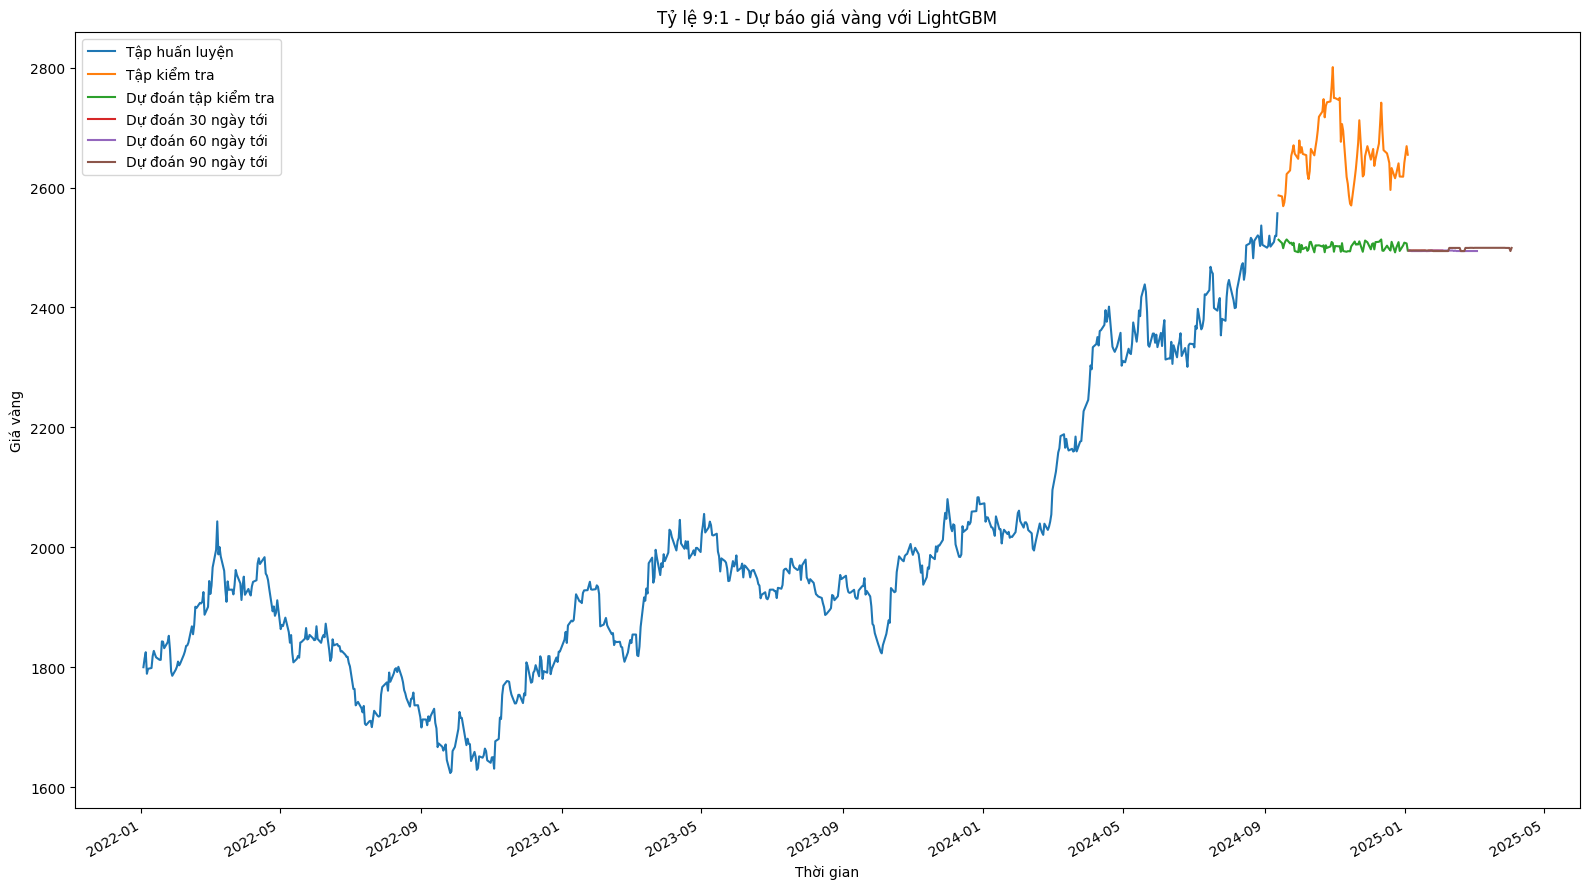

In [9]:
plt.figure(figsize=(16, 9))

# Vẽ tập huấn luyện
plt.plot(train_df["Date"], train_df["Price"], label="Tập huấn luyện")

# Vẽ kiểm tra và dự đoán
plt.plot(test_df["Date"], test_df["Price"], label="Tập kiểm tra")
plt.plot(test_df["Date"], test_df["pred"], label="Dự đoán tập kiểm tra")

# Vẽ dự đoán tương lai
plt.plot(future_30_df["ds"], future_30_df["pred"], label="Dự đoán 30 ngày tới")
plt.plot(future_60_df["ds"], future_60_df["pred"], label="Dự đoán 60 ngày tới")
plt.plot(future_90_df["ds"], future_90_df["pred"], label="Dự đoán 90 ngày tới")

plt.xlabel("Thời gian")
plt.ylabel("Giá vàng")
plt.title("Tỷ lệ 9:1 - Dự báo giá vàng với LightGBM")
plt.legend()
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()
